# Quantitative Revenue Modeling and Causal Inference from Marketing Data

This project presents a comprehensive quantitative analysis of historical marketing and sales data to **forecast revenue** and **evaluate the causal impact of various marketing channels and competitor activity**. Utilizing a **multi-methodological approach**, the study progresses from traditional statistical modeling to advanced Bayesian techniques.

The core objectives include:

* **Establishing a robust baseline for revenue prediction** using classical Ordinary Least Squares (OLS) regression, providing interpretable insights into key revenue drivers.
* **Exploring time-series methodologies** to capture inherent temporal dependencies and seasonal patterns in revenue data, enhancing forecasting accuracy.
* **Implementing Bayesian statistical models** to provide a probabilistic framework for parameter estimation and explicit **quantification of uncertainty** in forecasts.
* **Demonstrating Bayesian belief updating**, illustrating how prior domain knowledge can be formally integrated with empirical data to refine parameter estimates and test hypotheses about marketing effectiveness.

By rigorously applying these quantitative methods to a real-world dataset, this project showcases proficiency in **statistical modeling, time-series analysis, MCMC sampling, and Bayesian inference**.

## 1. Data Overview & Exploratory Data Analysis


This section outlines the process of data ingestion and initial exploratory data analysis (EDA) to understand the dataset's structure and key characteristics.

In [1]:
# Importing necessary libraries and loading the dataset
from google.colab import files
import pandas as pd

# Uploading the dataset from Google Colab
uploaded = files.upload()

# Unzipping and reading the data into a pandas DataFrame
df = pd.read_csv('sample_data.csv')

# Data Preprocessing: Converting 'DATE' column to datetime index for time-series analysis
df['DateTimeIndex'] = pd.to_datetime(df['DATE'])
df = df.set_index(keys=['DateTimeIndex'])

# Dropping redundant columns for cleaner analysis
df = df.drop(['X', 'DATE'], axis=1)

# Displaying descriptive statistics to understand data distribution and potential outliers
print(df.describe())

Saving sample_data.csv to sample_data.csv
            revenue      media1_S       media2_S       media3_S  \
count  2.080000e+02  2.080000e+02     208.000000     208.000000   
mean   1.822143e+06  1.113277e+05   27964.741987   64369.734789   
std    7.162286e+05  2.141877e+05   48623.026738   94810.914100   
min    6.722500e+05  0.000000e+00       0.000000       0.000000   
25%    1.165211e+06  0.000000e+00       0.000000       0.000000   
50%    1.874514e+06  0.000000e+00       0.000000       0.000000   
75%    2.378407e+06  1.380503e+05   35758.750000  108690.366986   
max    3.827520e+06  1.185349e+06  239417.333333  462011.742240   

       competitor_sales    newsletter  
count      2.080000e+02    208.000000  
mean       5.538025e+06  22386.523077  
std        2.077192e+06  19104.164517  
min        2.240235e+06    301.000000  
25%        3.589581e+06   9010.500000  
50%        5.538524e+06  19401.650000  
75%        7.311814e+06  27546.500000  
max        9.984742e+06  96236.000

### Exploratory Data Analysis

### Visualizing Relationships with Pairplots

To gain insights into the interrelationships between variables, a pairplot was generated. This visualization helps identify potential correlations and distributions within the dataset.

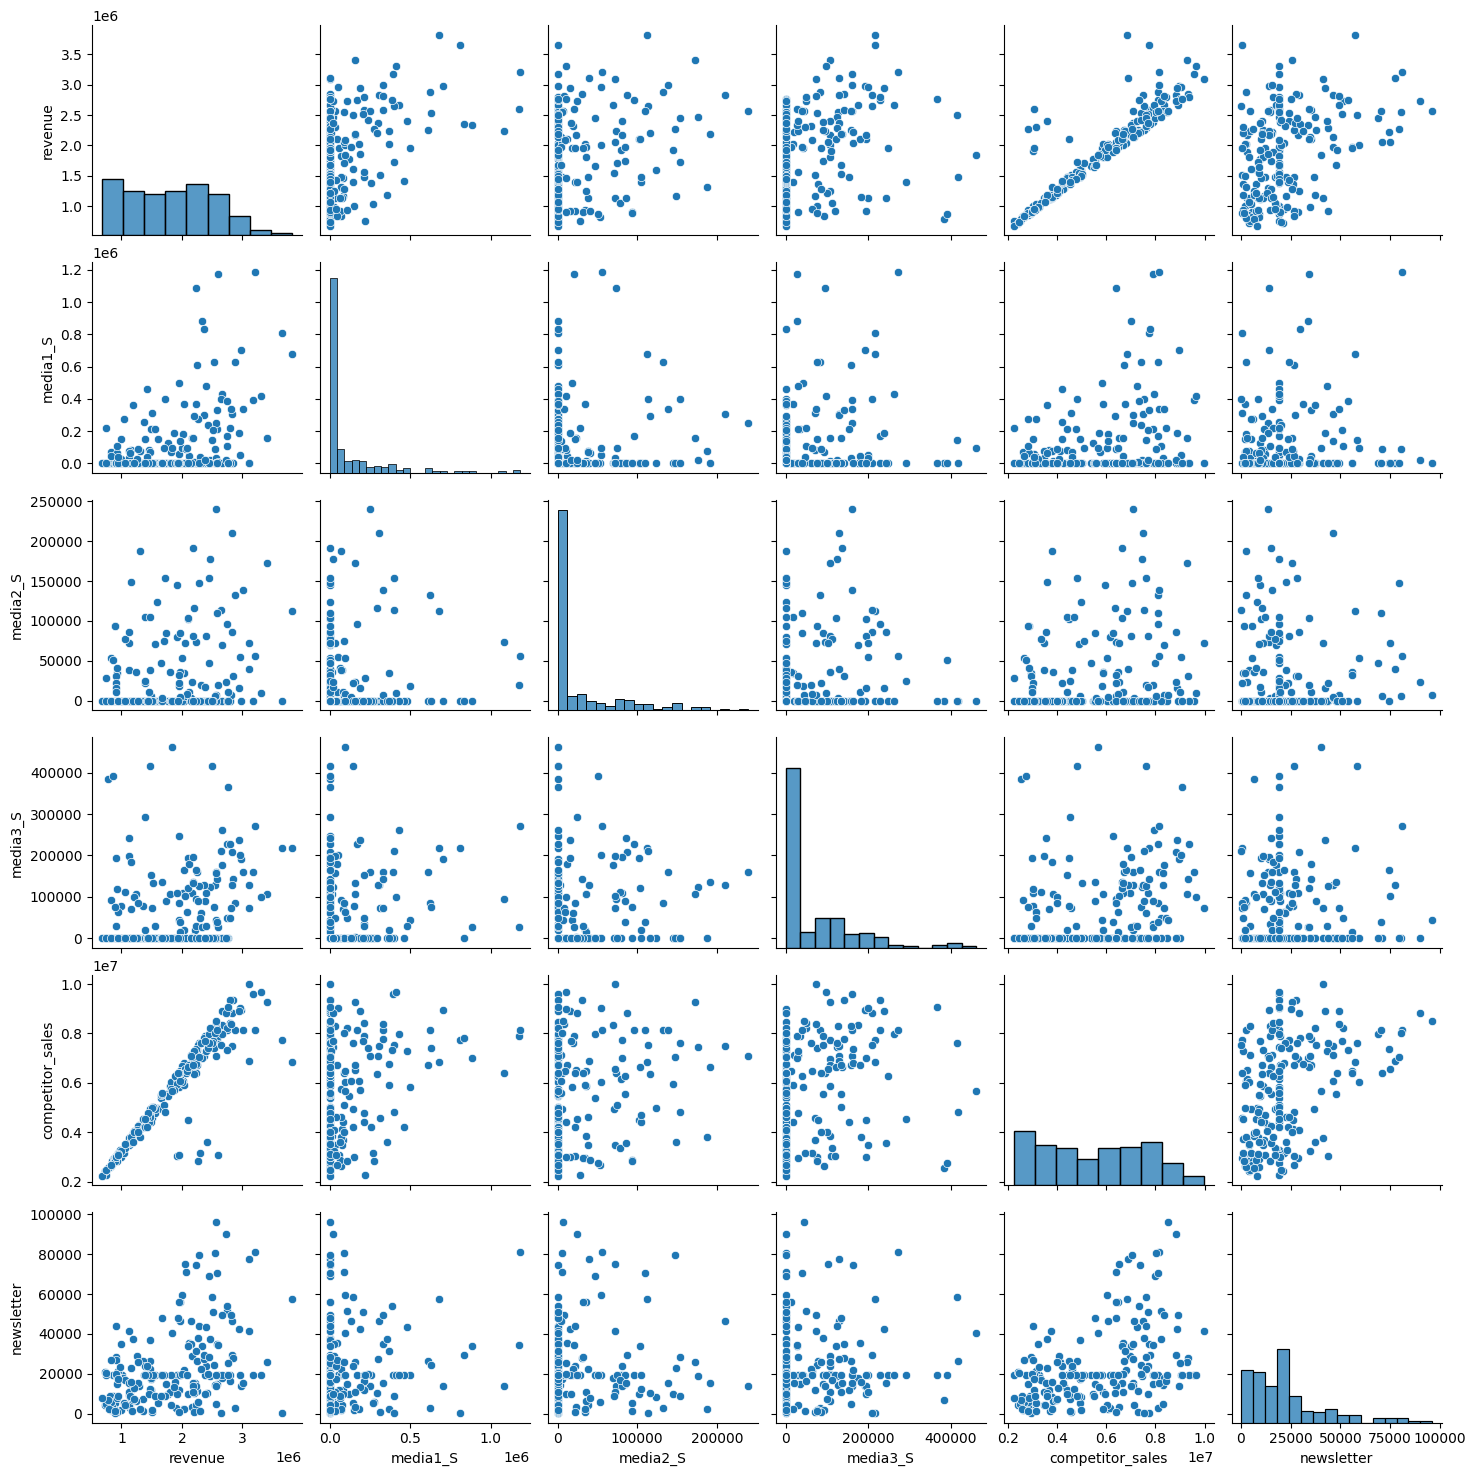


Correlation Matrix:
                   revenue  media1_S  media2_S  media3_S  competitor_sales  \
revenue           1.000000  0.419869  0.230415  0.317594          0.916454   
media1_S          0.419869  1.000000  0.060642  0.147446          0.305138   
media2_S          0.230415  0.060642  1.000000  0.130766          0.179306   
media3_S          0.317594  0.147446  0.130766  1.000000          0.289349   
competitor_sales  0.916454  0.305138  0.179306  0.289349          1.000000   
newsletter        0.406099  0.099835  0.042412  0.106135          0.432082   

                  newsletter  
revenue             0.406099  
media1_S            0.099835  
media2_S            0.042412  
media3_S            0.106135  
competitor_sales    0.432082  
newsletter          1.000000  


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df)
plt.show()

print("\nCorrelation Matrix:")
print(df.corr())

### Observations from Pairplot Analysis

Initial observations from the pairplot reveal:

* **Sparse Media Data:** The media-related columns (columns 2-4 in the first row) exhibit a high concentration of zero entries, leading to a clustering of data points along the y-axis when plotted against revenue.
* **Strong Positive Correlation:** A clear and **strong positive linear relationship** is evident between `revenue` and `competitor_sales`. This indicates that competitor performance significantly influences revenue and could be a key predictive variable in future models.

## 2. Predictive Modeling: Revenue Forecasting with Ordinary Least Squares (OLS) Regression

This section focuses on developing a predictive model for revenue using a classical regression approach. The aim is to establish a baseline forecast and understand the linear relationships between marketing spend, competitive factors, and revenue.

### Model Selection and Sparsity Assessment

Before applying a standard linear model, it's crucial to assess the data's characteristics. The **Hoyer measure of sparsity** (or Hoyer index) is calculated to quantify the sparseness of each feature. This helps determine the suitability of a multiple linear regression model.

In [3]:
import numpy as np
import math

# Calculate Hoyer measure for each column
# The Hoyer measure assesses the 'peakiness' of a vector, with 0 for dense vectors
# and 1 for maximally sparse vectors (e.g., all but one element is zero).
sparse_measures = []
n_observations = df.shape[0]
sqrt_n_obs = math.sqrt(n_observations)

for column_name in df.columns:
    # Ensure numerical data for norm calculations
    if pd.api.types.is_numeric_dtype(df[column_name]):
        # Check for division by zero if norm is zero (e.g., all zeros in column)
        l1_norm = np.linalg.norm(df[column_name], 1)
        l2_norm = np.linalg.norm(df[column_name], 2)

        if l2_norm != 0: # Avoid division by zero
            hoyer_measure = (sqrt_n_obs - (l1_norm / l2_norm)) / (sqrt_n_obs - 1)
            sparse_measures.append(hoyer_measure)
        else:
            sparse_measures.append(1.0) # Max sparsity if all zeros
    else:
        sparse_measures.append(np.nan) # Handle non-numeric columns appropriately

# Display the calculated sparsity measures for each feature
print("Hoyer Measures of Sparsity for each feature:")
for i, col in enumerate(df.columns):
    if i < len(sparse_measures): # Ensure index is within bounds
        print(f"- {col}: {sparse_measures[i]:.4f}")

Hoyer Measures of Sparsity for each feature:
- revenue: 0.0742
- media1_S: 0.5780
- media2_S: 0.5378
- media3_S: 0.4700
- competitor_sales: 0.0681
- newsletter: 0.2563


**Interpretation of Sparsity:**

Given the calculated Hoyer measures, the overall sparsity of the key predictive features is deemed manageable for a standard Ordinary Least Squares (OLS) regression. While some media features show higher sparsity, the decision is made to proceed with OLS as a robust baseline, acknowledging that more sophisticated models could address this in future iterations.

### Model Specification and Training

An OLS regression model is constructed to predict `revenue` based on selected media expenditures, `competitor_sales`, and `newsletter` activity. The dataset is split into training and testing sets to evaluate the model's out-of-sample performance.

In [4]:
import statsmodels.api as sm
from patsy import dmatrices # Used for easy formula-based model specification

# Define the regression formula
# The formula syntax allows for clear definition of dependent and independent variables.
expr = 'revenue ~ media1_S + media2_S + media3_S + competitor_sales + newsletter'

# Prepare data for statsmodels using patsy.dmatrices, which automatically adds an intercept
# Splitting data into training (first 200 observations) and testing sets (remaining observations)
train_split_point = 200
y_train, X_train = dmatrices(expr, df.iloc[:train_split_point], return_type='dataframe')
y_test, X_test = dmatrices(expr, df.iloc[train_split_point:], return_type='dataframe')

# Fit the OLS model on the training data
ols_model = sm.OLS(y_train, X_train).fit()

# Display the comprehensive summary of the regression results
# This includes coefficients, p-values, R-squared, and other diagnostic statistics.
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     244.8
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           9.58e-82
Time:                        21:01:34   Log-Likelihood:                -2781.0
No. Observations:                 200   AIC:                             5574.
Df Residuals:                     194   BIC:                             5594.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         9.959e+04   5.43e+04  

**Interpretation of Regression Results:**

Based on the p-values from the OLS regression summary:

* **Statistically Significant Predictors:** `competitor_sales`, `media1_S`, and `media2_S` exhibit strong statistical significance (p-value < 0.05), indicating a robust relationship with `revenue`. This suggests these factors are key drivers of revenue.
* **Coefficient Interpretation:** The coefficients provide insights into the marginal impact of each predictor:
    * A one-unit increase in `media1_S` is associated with approximately a **0.50 unit increase in `revenue`**, holding other variables constant.
    * A one-unit increase in `media2_S` is associated with approximately a **0.96 unit increase in `revenue`**, holding other variables constant.
    * A one-unit increase in `competitor_sales` is associated with approximately a **0.29 unit increase in `revenue`**, holding other variables constant.

These findings highlight the quantifiable impact of marketing efforts and competitive dynamics on revenue, providing actionable insights for strategic decision-making.

### Out-of-Sample Prediction and Visualization of Forecast Intervals

The trained OLS model is used to generate out-of-sample predictions on the test set. Furthermore, **confidence intervals (for the mean prediction)** and **prediction intervals (for individual observations)** are calculated and visualized. This demonstrates the model's predictive uncertainty.

<ipython-input-5-551299666>:25: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(forecast_df.index, forecast_df['Upper Confidence Interval'], color='grey', linestyle='--', label='95% Upper CI')


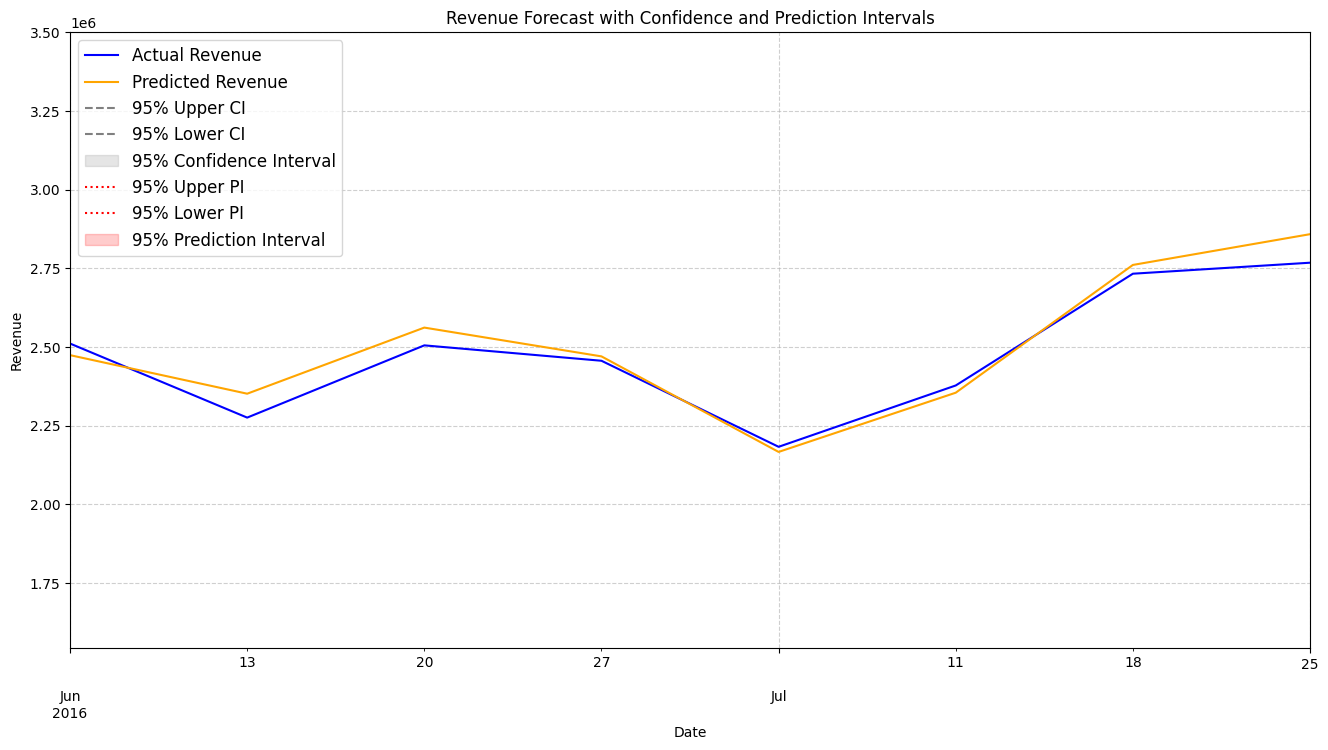

In [5]:
# Generate predictions on the test set, including confidence and prediction intervals
predictions = ols_model.get_prediction(X_test)
prediction_summary_frame = predictions.summary_frame(alpha=0.05) # 95% intervals

# Consolidate actuals, predictions, and intervals into a single DataFrame for plotting
forecast_df = pd.concat([y_test,
                         prediction_summary_frame[['mean',
                                                   'obs_ci_lower', 'obs_ci_upper',
                                                   'mean_ci_lower', 'mean_ci_upper']]],
                        axis=1)

forecast_df.columns = ['Actual Revenue', 'Predicted Revenue',
                       'Lower Prediction Interval', 'Upper Prediction Interval',
                       'Lower Confidence Interval', 'Upper Confidence Interval']

# Plotting the actual vs. predicted revenue with confidence and prediction intervals
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)

# Plot actual and predicted values
forecast_df['Actual Revenue'].plot(ax=ax, color='blue', label='Actual Revenue')
forecast_df['Predicted Revenue'].plot(ax=ax, color='orange', label='Predicted Revenue')

# Plot confidence intervals (CI) for the mean prediction
ax.plot(forecast_df.index, forecast_df['Upper Confidence Interval'], color='grey', linestyle='--', label='95% Upper CI')
ax.plot(forecast_df.index, forecast_df['Lower Confidence Interval'], color='grey', linestyle='--', label='95% Lower CI')
ax.fill_between(forecast_df.index, forecast_df['Lower Confidence Interval'], forecast_df['Upper Confidence Interval'],
                color='grey', alpha=0.2, label='95% Confidence Interval')

# Plot prediction intervals (PI) for individual observations
ax.plot(forecast_df.index, forecast_df['Upper Prediction Interval'], color='red', linestyle=':', label='95% Upper PI')
ax.plot(forecast_df.index, forecast_df['Lower Prediction Interval'], color='red', linestyle=':', label='95% Lower PI')
ax.fill_between(forecast_df.index, forecast_df['Lower Prediction Interval'], forecast_df['Upper Prediction Interval'],
                color='red', alpha=0.2, label='95% Prediction Interval')

ax.set_title('Revenue Forecast with Confidence and Prediction Intervals')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
ax.legend(loc='upper left', fontsize=12) # Moved legend for better visibility
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate common regression evaluation metrics
mae = mean_absolute_error(forecast_df['Actual Revenue'], forecast_df['Predicted Revenue'])
rmse = mean_squared_error(forecast_df['Actual Revenue'], forecast_df['Predicted Revenue'])**0.5

print(f'Model Performance on Test Set:')
print(f'  Mean Absolute Error (MAE): {mae:.4f}')
print(f'  Root Mean Squared Error (RMSE): {rmse:.4f}')

Model Performance on Test Set:
  Mean Absolute Error (MAE): 42613.4459
  Root Mean Squared Error (RMSE): 50361.2890


## 3. Predictive Modeling: Revenue Forecasting with Time-Series Models

This section explores the application of time-series methodologies to capture temporal dependencies and seasonality in the revenue data, aiming to improve forecasting accuracy beyond classical regression.

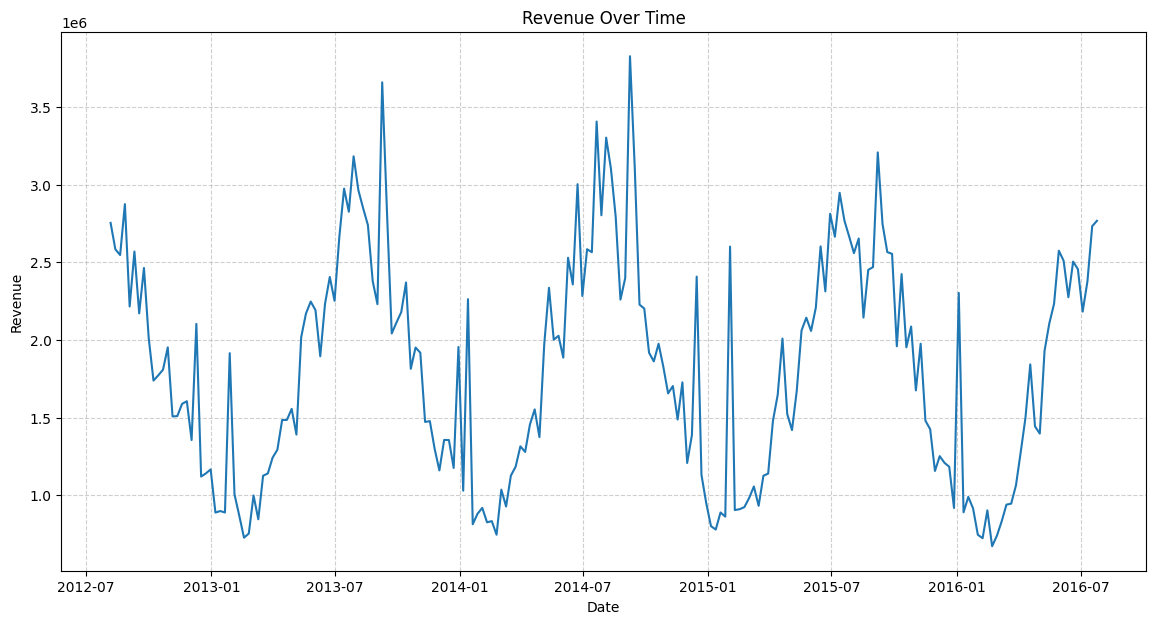

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the revenue time series to identify trends and seasonality
plt.figure(figsize=(14, 7))
sns.lineplot(data=df['revenue'])
plt.title('Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Time Series Characteristics and Model Selection

Visual inspection of the revenue time series reveals a strong seasonal pattern, with a dominant period of approximately 12 months (or 52 weeks). There appear to be roughly two peaks within each annual cycle: one around a month before September and another in the first week of September. This seasonality aligns intuitively with an education industry context, where revenue might surge around academic year commencements.

To account for these temporal considerations, a Seasonal Autoregressive Integrated Moving Average with eXogenous regressors (SARIMAX) model is a suitable choice. This model can explicitly capture autocorrelation, trend, and seasonality.

First, we examine the Autocorrelation Function (ACF) plot of the residuals from the previously fitted OLS model to identify any remaining unexplained temporal dependencies. Significant autocorrelations in the residuals indicate that the OLS model has not fully captured the time-series structure.

<Figure size 1200x600 with 0 Axes>

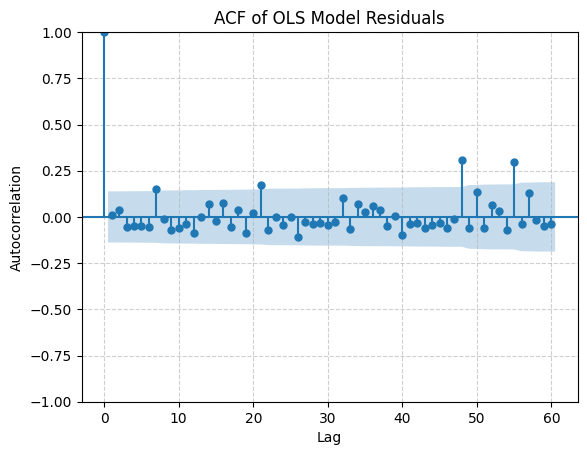

In [8]:
import statsmodels.graphics.tsaplots as tsa

# Plot ACF of OLS residuals to identify remaining autocorrelation
plt.figure(figsize=(12, 6))
tsa.plot_acf(ols_model.resid, lags=60, title='ACF of OLS Model Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

The ACF plot shows strong and significant autocorrelations near lag 52, confirming the presence of a yearly seasonal pattern not fully captured by the OLS model. To address this, we apply a seasonal difference of period 52 to the OLS residuals and re-examine the ACF. This differencing step helps in achieving stationarity for the seasonal component.

<Figure size 1200x600 with 0 Axes>

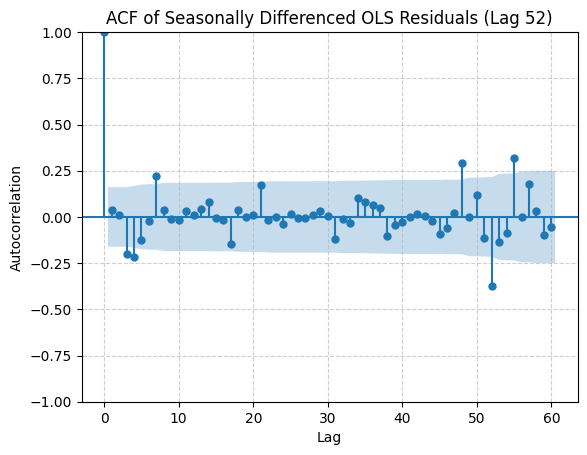

In [9]:
# Apply a seasonal difference of 52 weeks to the OLS residuals
olsr_resid_52_diff = ols_model.resid.diff(periods=52).dropna()

# Plot ACF of the seasonally differenced residuals
plt.figure(figsize=(12, 6))
tsa.plot_acf(olsr_resid_52_diff, lags=60, title='ACF of Seasonally Differenced OLS Residuals (Lag 52)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

The ACF plot of the seasonally differenced residuals indicates that further differencing is not strictly necessary for stationarity, as the significant autocorrelation at lag 52 has been largely removed.

Ideally, a SARIMAX model with a seasonal order of $(P,D,Q)_S$​ where $D=1$ and $S=52$ (e.g., $(0,1,1)_{52}$​) would be appropriate to directly model this seasonal differencing. However, the `statsmodels` ARIMA implementation typically requires at least five full seasonal periods in the data to reliably estimate seasonal parameters. Given our dataset's length, this constraint becomes a limiting factor for directly applying a $(P,1,Q)_{52}$​ seasonal order.

Therefore, as an alternative, we will fit a SARIMAX(1,0,1)(0,1,1)52 model. It's important to note that due to the data length constraint, the seasonal component `(0,1,1)52` might not be fully effective in capturing the deep seasonal patterns if sufficient periods aren't present. The (1,0,1) non-seasonal component aims to capture any remaining autoregressive and moving average dynamics after the implied seasonal differencing from the seasonal_order parameter. This approach provides a balance between model complexity and data availability.

### Times series Prediction and Visualization

In [10]:
from statsmodels.tsa.arima.model import ARIMA

# Prepare exogenous variables and endogenous variable for SARIMAX
# Ensure the indices are consistent and frequency is set for time series modeling
# Drop the intercept column as SARIMAX handles it internally if not explicitly specified via fit()
X_train_sarimax = X_train.drop('Intercept', axis=1)
y_train_sarimax = y_train

X_test_sarimax = X_test.drop('Intercept', axis=1)
y_test_sarimax = y_test

# Ensure time series frequency is set (e.g., weekly) for proper SARIMAX handling
# This helps in handling missing dates or ensuring correct date alignment.
# We'll re-index to a weekly frequency, filling any gaps if necessary.
# For simplicity, we assume the original index already has a consistent weekly frequency.
# If not, a more robust re-indexing with `asfreq` and `fillna` might be needed.
# For this dataset, assuming 'W-Mon' (Weekly, ending Monday) as default frequency if data is weekly.
X_train_sarimax = X_train_sarimax.asfreq('W-MON')
y_train_sarimax = y_train_sarimax.asfreq('W-MON')
X_test_sarimax = X_test_sarimax.asfreq('W-MON')
y_test_sarimax = y_test_sarimax.asfreq('W-MON')

# Fit the SARIMAX model
# order=(p,d,q): (AR order, differencing order, MA order)
# seasonal_order=(P,D,Q,S): (Seasonal AR order, Seasonal differencing order, Seasonal MA order, Seasonal period)
sarimax_model = ARIMA(endog=y_train_sarimax,
                      exog=X_train_sarimax,
                      order=(1,0,1),           # Non-seasonal AR(1), I(0), MA(1)
                      seasonal_order=(0,1,1,52)) # Seasonal AR(0), I(1) for seasonal differencing, MA(1) with period 52

sarimax_results = sarimax_model.fit()

# Display the SARIMAX model summary, including coefficients, p-values, and diagnostic tests
print(sarimax_results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                     
Dep. Variable:                          revenue   No. Observations:                  200
Model:             ARIMA(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood               -2089.326
Date:                          Tue, 17 Jun 2025   AIC                           4196.652
Time:                                  21:02:27   BIC                           4223.627
Sample:                              08-06-2012   HQIC                          4207.612
                                   - 05-30-2016                                         
Covariance Type:                            opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
media1_S             0.5282      0.286      1.846      0.065      -0.033       1.089
media2_S             0.7257      

From the Ljung-Box test statistic in the SARIMAX summary, we observe a high p-value ( > 0.05), which indicates strong evidence that the residuals of the SARIMAX model have no significant autocorrelation. This suggests that the model has effectively captured the underlying time-series structure and the model's assumptions are largely met.

Next, we generate forecasts using the fitted SARIMAX model and visualize them against the actual test data, including confidence intervals to quantify prediction uncertainty.

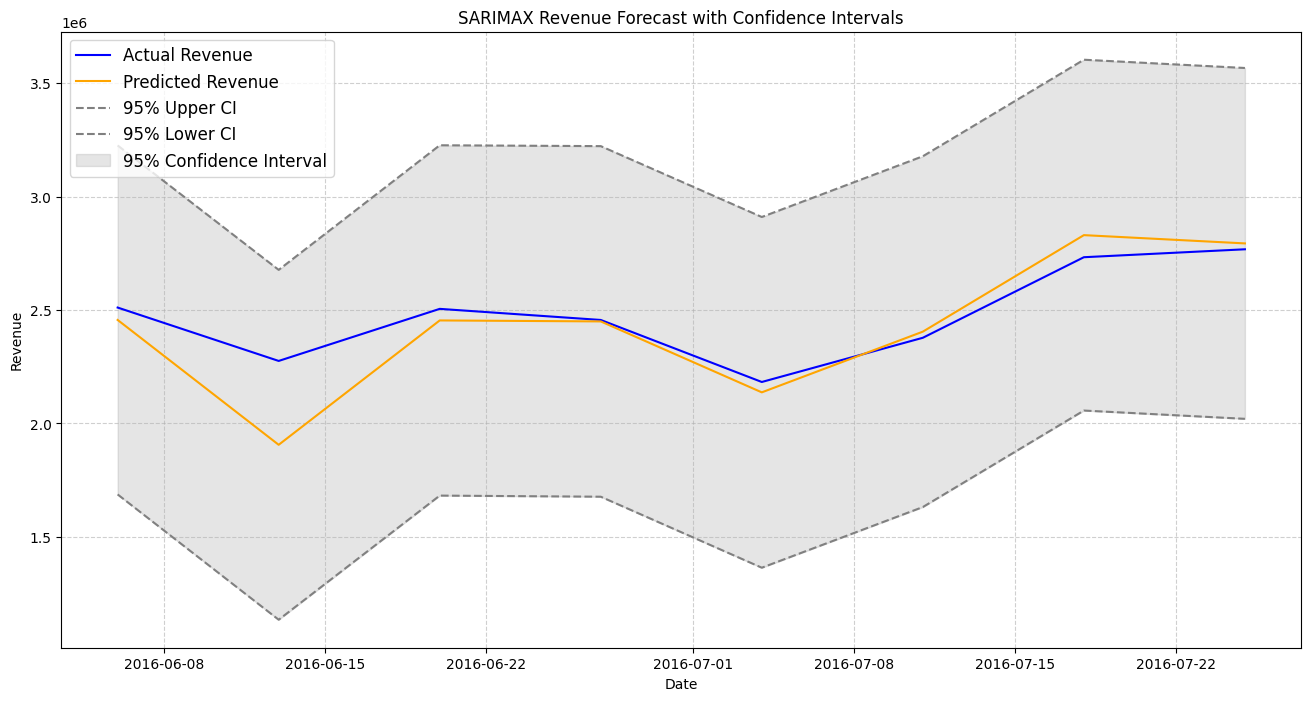

In [11]:
# Generate in-sample predictions and out-of-sample forecasts with confidence intervals
# We forecast for the length of the test set, using the test exogenous variables
forecast_sarimax = sarimax_results.get_forecast(steps=len(y_test_sarimax), exog=X_test_sarimax)
sarimax_summary_frame = forecast_sarimax.summary_frame(alpha=0.05) # 95% confidence intervals

# Consolidate actuals, predictions, and confidence intervals for plotting
forecast_df_sarimax = pd.concat([y_test_sarimax,
                                 sarimax_summary_frame[['mean', 'mean_ci_lower', 'mean_ci_upper']]],
                                axis=1)
forecast_df_sarimax.columns = ['Actual Revenue', 'Predicted Revenue',
                               'Lower Confidence Interval', 'Upper Confidence Interval']

# Plotting the actual vs. predicted revenue with confidence intervals
plt.figure(figsize=(16, 8))
plt.plot(forecast_df_sarimax.index, forecast_df_sarimax['Actual Revenue'], color='blue', label='Actual Revenue')
plt.plot(forecast_df_sarimax.index, forecast_df_sarimax['Predicted Revenue'], color='orange', label='Predicted Revenue')

plt.plot(forecast_df_sarimax.index, forecast_df_sarimax['Upper Confidence Interval'], color='grey', linestyle='--', label='95% Upper CI')
plt.plot(forecast_df_sarimax.index, forecast_df_sarimax['Lower Confidence Interval'], color='grey', linestyle='--', label='95% Lower CI')
plt.fill_between(forecast_df_sarimax.index, forecast_df_sarimax['Lower Confidence Interval'], forecast_df_sarimax['Upper Confidence Interval'],
                 color='grey', alpha=0.2, label='95% Confidence Interval')

plt.title('SARIMAX Revenue Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate evaluation metrics for the SARIMAX model
mae_sarimax = mean_absolute_error(forecast_df_sarimax['Actual Revenue'], forecast_df_sarimax['Predicted Revenue'])
rmse_sarimax = mean_squared_error(forecast_df_sarimax['Actual Revenue'], forecast_df_sarimax['Predicted Revenue'])**0.5

print(f'SARIMAX Model Performance on Test Set:')
print(f'  Mean Absolute Error (MAE): {mae_sarimax:.4f}')
print(f'  Root Mean Squared Error (RMSE): {rmse_sarimax:.4f}')

SARIMAX Model Performance on Test Set:
  Mean Absolute Error (MAE): 84715.2816
  Root Mean Squared Error (RMSE): 139305.9958


The calculated MAE and RMSE for the SARIMAX model are observed to be larger than those from the previous multiple linear regression model. This outcome, while initially counter-intuitive for a specialized time-series model, is largely as expected given the data constraints. As noted, the `statsmodels` package's SARIMAX implementation generally requires at least five full seasonal periods to effectively estimate the seasonal components. With limited seasonal cycles in our training data, the model's ability to fully capture and leverage the strong 52-week seasonality is constrained, leading to less accurate forecasts compared to a simpler OLS model that doesn't attempt to explicitly model these complex temporal dependencies with insufficient data. This highlights a crucial challenge in time-series forecasting: the trade-off between model sophistication and data availability.


## 4. Bayesian Model Estimation

This section introduces a Bayesian framework for revenue forecasting. Bayesian methods provide a probabilistic approach to parameter estimation, allowing for the incorporation of prior knowledge and a direct quantification of uncertainty in predictions.

### Bayesian Model Specification with Weakly Informative Priors

To implement the Bayesian model, we'll use the `bambi` library, which simplifies model specification using a familiar R-like formula syntax and leverages `PyMC` for robust Markov Chain Monte Carlo (MCMC) sampling.

In [13]:
pip install bambi

In [14]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt # Ensure this is imported if not already
import numpy as np # Ensure this is imported if not already
import pandas as pd # Ensure this is imported if not already

# Set ArviZ style for consistent plots and define a random seed for reproducibility
az.style.use("arviz-darkgrid")
SEED = 114514

# Define the Bayesian model using the same formula as the OLS model
# Bambi automatically sets default (weakly informative) priors for the parameters.
bayesian_model = bmb.Model(expr, df.iloc[:200])

# Display the model structure and default priors
print(bayesian_model)

       Formula: revenue ~ media1_S + media2_S + media3_S + competitor_sales + newsletter
        Family: gaussian
          Link: mu = identity
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1795982.8917, sigma: 5799533.6451)
            media1_S ~ Normal(mu: 0.0, sigma: 8.2357)
            media2_S ~ Normal(mu: 0.0, sigma: 37.4497)
            media3_S ~ Normal(mu: 0.0, sigma: 19.8713)
            competitor_sales ~ Normal(mu: 0.0, sigma: 0.8691)
            newsletter ~ Normal(mu: 0.0, sigma: 99.1134)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 715330.9566)


**Prior Specification:**

By default, the `bambi` package assigns **weakly informative priors** to the model parameters. Specifically:

* **Regression Coefficients (e.g., `media1_S`, `media2_S`, `media3_S`, `competitor_sales`, `newsletter`):** These parameters are assigned **Normal distributions centered at zero ($N(0, \sigma^2)$)**. As discussed in [Piironen & Vehtari (2017)](https://arxiv.org/abs/1702.01201), the scale parameter $\sigma$ in these default priors is implicitly linked to the partial correlation scale, making them "weakly informative" rather than truly non-informative. This helps regularize the model without imposing strong, subjective beliefs.
* **Error Standard Deviation (`revenue_sigma`):** The standard deviation of the error term (or residual standard deviation) is assigned a **Half-StudentT distribution**. This choice is common for scale parameters in Bayesian modeling as it's restricted to positive values and has heavier tails than a Half-Normal, offering more flexibility.

It's important to note that these default priors are **not conjugate** for a linear regression model (where a conjugate prior for the variance would typically be an Inverse-Gamma distribution, as seen in classical Bayesian linear regression setups like those on [Wikipedia](https://en.wikipedia.org/wiki/Bayesian_linear_regression)). The use of non-conjugate priors necessitates more advanced sampling algorithms.

**Markov Chain Monte Carlo (MCMC) Sampling:**

To estimate the posterior distributions of the model parameters, a **No-U-Turn Sampler (NUTS) algorithm** (as detailed in [Hoffman & Gelman, 2014](http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf)) is employed. NUTS is a type of Hamiltonian Monte Carlo (HMC) algorithm, known for its efficiency and faster convergence to the target distribution compared to simpler MCMC methods like Metropolis-Hastings or Gibbs sampling. A key advantage of NUTS is its ability to automatically tune parameters such as the number of steps and step size, significantly reducing the manual effort often required for effective HMC sampling. This automation makes it robust for a wide range of models.

### Convergence Diagnostics of MCMC Chains

Output()

<ipython-input-15-3286135360>:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout() # Adjust layout to prevent overlaps


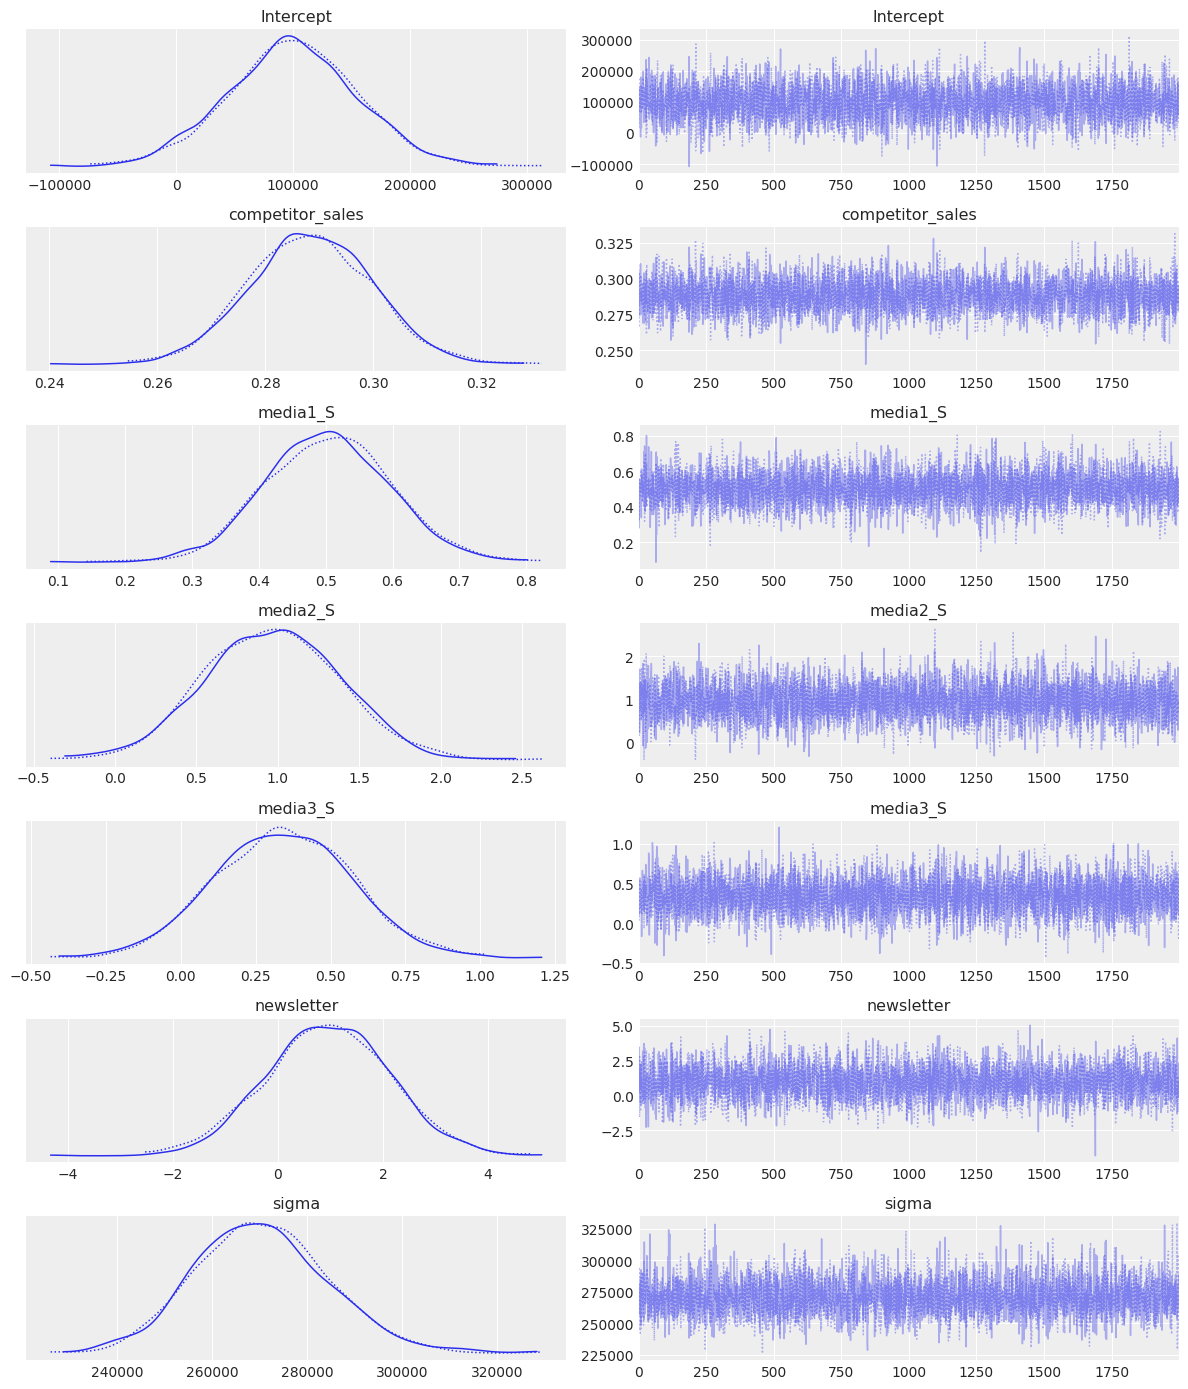

In [15]:
# Fit the Bayesian model using NUTS sampler
# 'tune' specifies the number of tuning (warm-up) samples, 'draws' specifies the number of samples from the posterior.
# 'init="adapt_diag"' is a common initialization method for HMC.
fitted_bayesian_model = bayesian_model.fit(tune=2000, draws=2000, init="adapt_diag", random_seed=SEED)

# Plot trace plots for all parameters
# Trace plots visualize the sampled values of parameters over iterations.
# They are crucial for assessing chain convergence and mixing.
az.plot_trace(fitted_bayesian_model);
plt.tight_layout() # Adjust layout to prevent overlaps
plt.show()

**Interpretation of Trace Plots:**

For all model parameters, the trace plots exhibit good **mixing**, characterized by dense, fuzzy caterpillar-like patterns where the samples oscillate randomly around a stable mean. This visual inspection suggests that the Markov Chains have **converged well** and are exploring the posterior distribution effectively, indicating reliable parameter estimates.

<ipython-input-16-2442671103>:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout() # Adjust layout


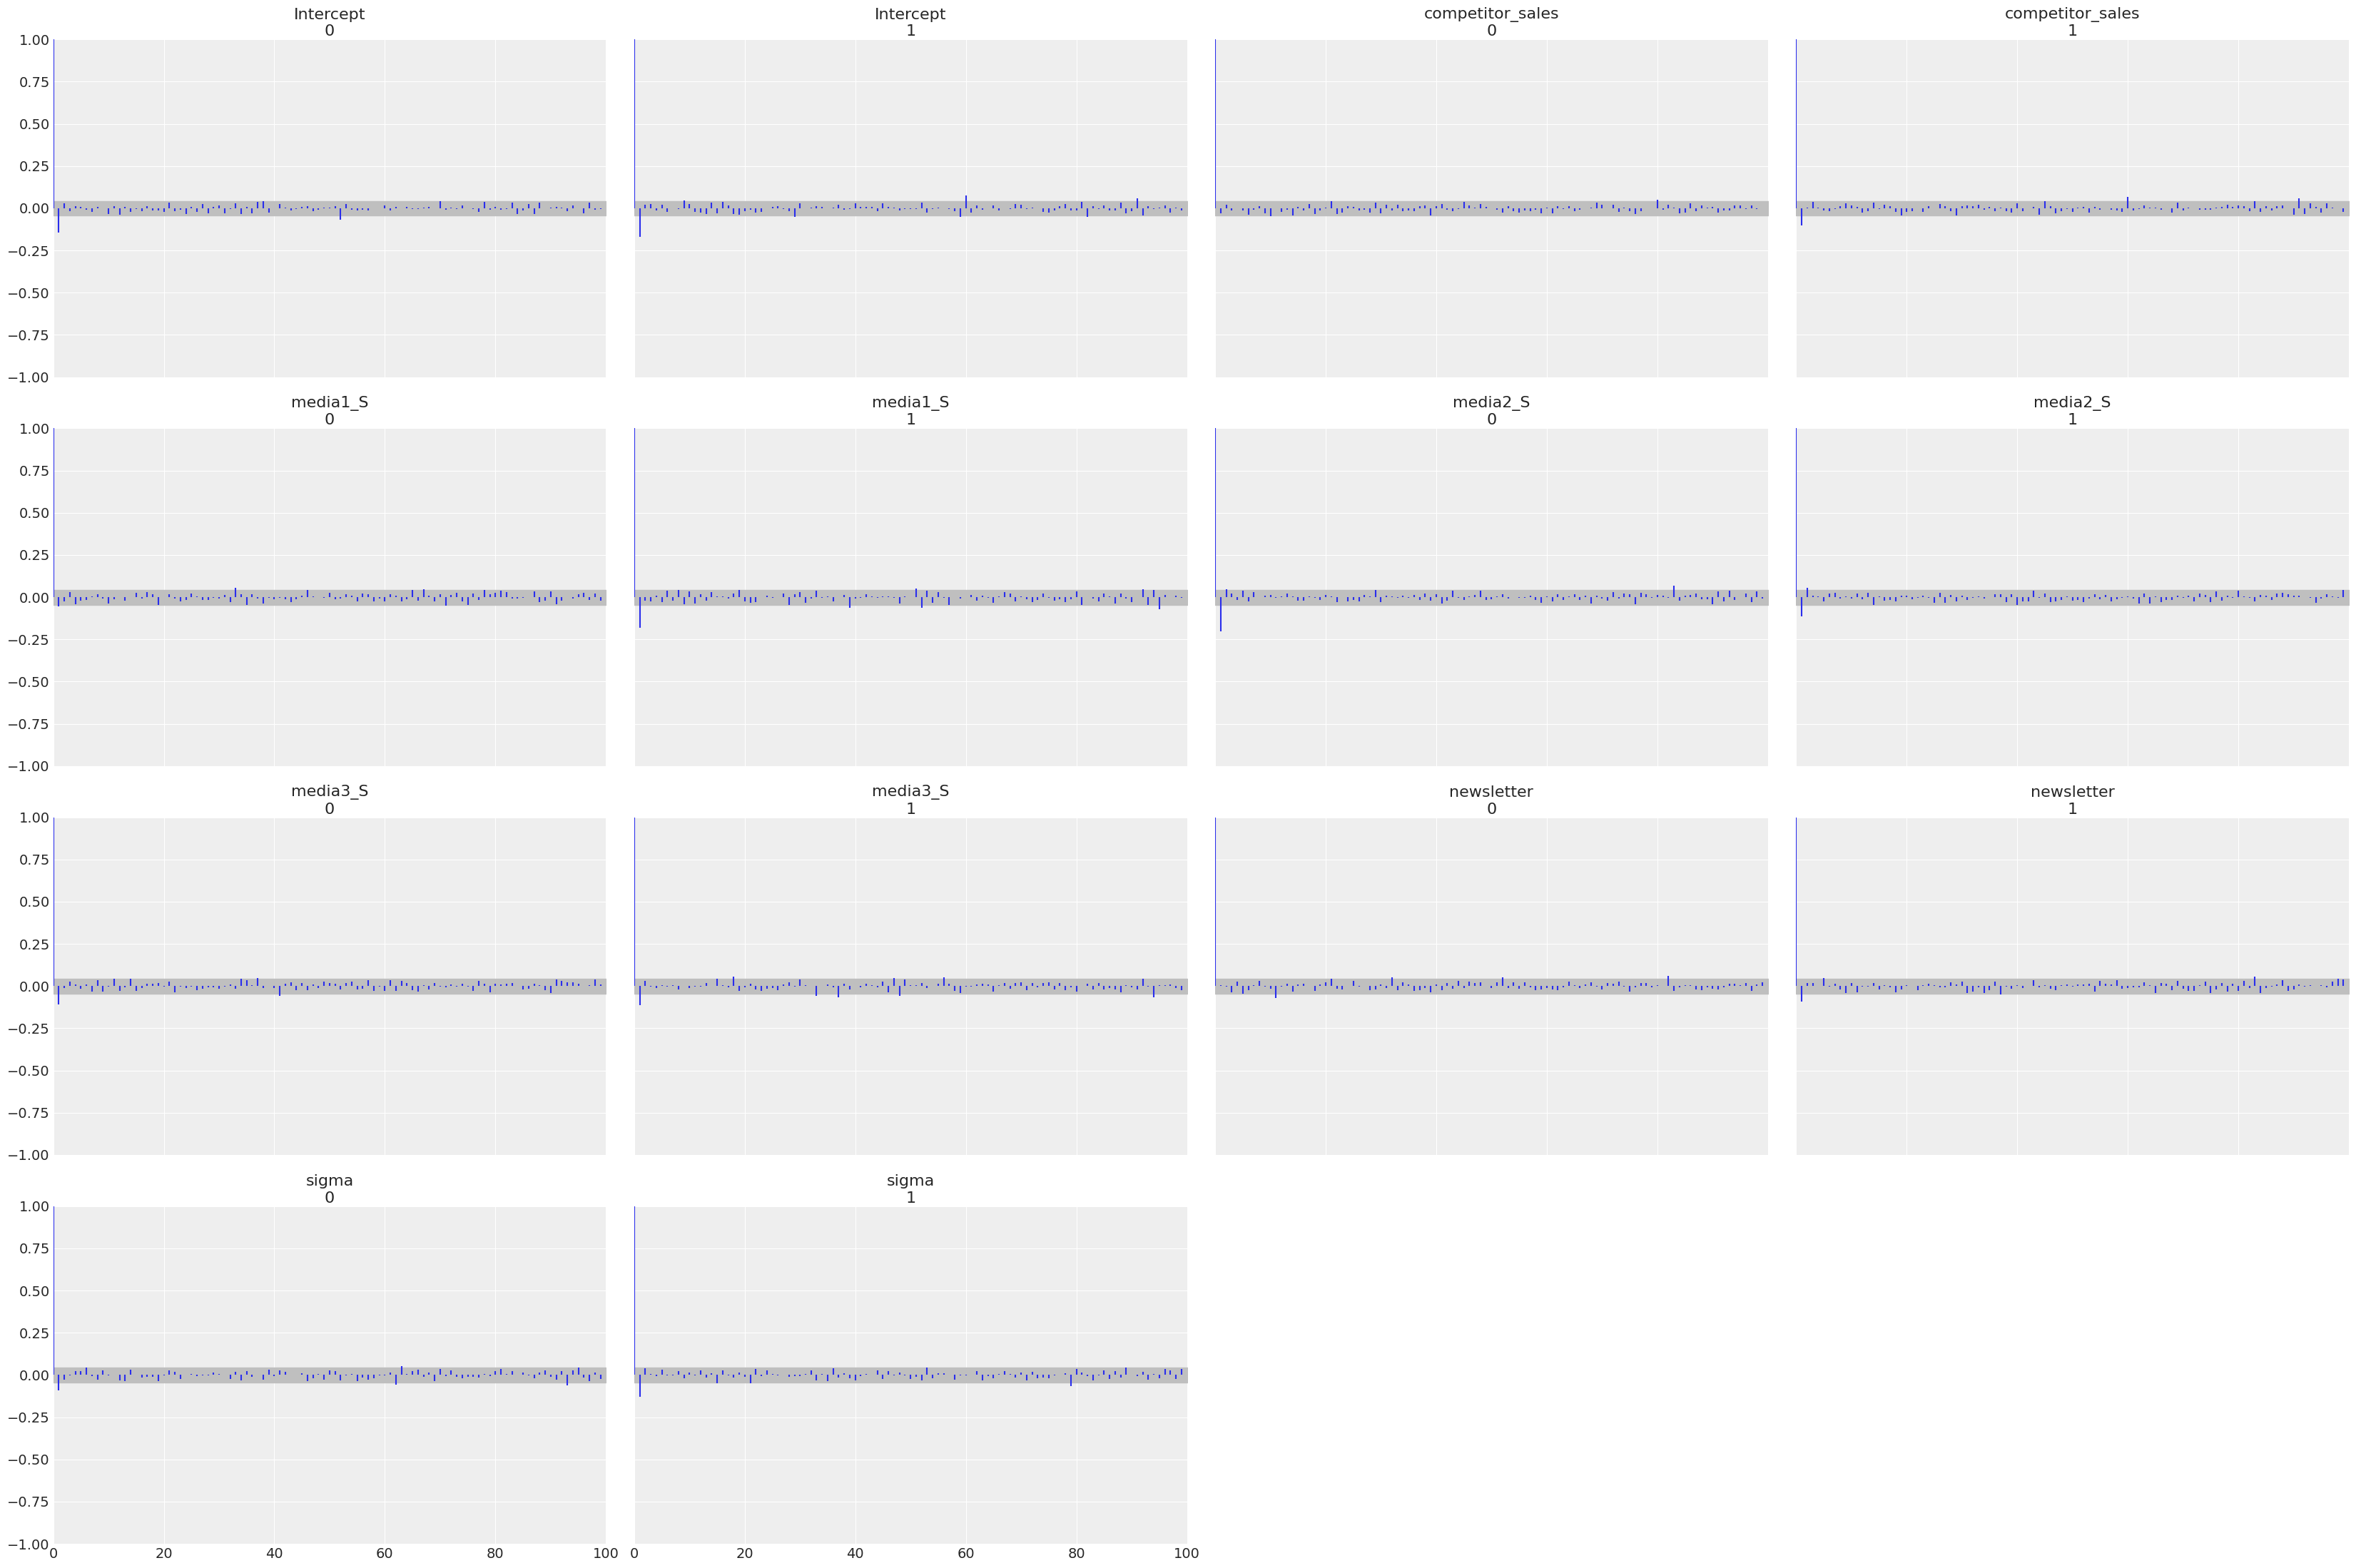

In [16]:
# Plot autocorrelation plots for all parameters
# Autocorrelation plots show the correlation between samples at different lags.
# Low autocorrelation indicates efficient sampling.
az.plot_autocorr(fitted_bayesian_model);
plt.tight_layout() # Adjust layout
plt.show()

**Interpretation of Autocorrelation Plots:**

The autocorrelation plots for all parameters show that **autocorrelation drops quickly to approximately zero at low lags**. This is an excellent indication that the samples drawn from the MCMC chains are largely **independent**, implying efficient sampling and good exploration of the posterior space. High autocorrelation would suggest the chains are not mixing well and potentially getting stuck, requiring longer runs or re-parametrization.

### Posterior Summaries and Prediction Insights

In [17]:
# Display a summary of the posterior distributions of the model parameters
# This includes mean, standard deviation, and various credible intervals.
az.summary(fitted_bayesian_model)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,99138.868,55174.134,-6952.060,198983.260,763.964,788.684,5190.0,3567.0,1.0
competitor_sales,0.288,0.011,0.267,0.310,0.000,0.000,4400.0,3589.0,1.0
media1_S,0.503,0.094,0.337,0.685,0.001,0.002,5277.0,3494.0,1.0
media2_S,0.965,0.417,0.205,1.746,0.006,0.006,4929.0,3072.0,1.0
media3_S,0.341,0.227,-0.080,0.766,0.003,0.003,4876.0,2946.0,1.0
newsletter,0.958,1.171,-1.227,3.147,0.018,0.017,4361.0,3577.0,1.0
sigma,270510.601,14260.115,244326.043,297606.053,203.110,251.324,4963.0,2562.0,1.0


**Comparison with OLS Results:**

As anticipated, with the use of **weakly informative priors** and a sufficient amount of data (where the likelihood dominates the prior), the **mean posterior estimates and standard deviations of the parameters are very similar to the point estimates and standard errors obtained from the classical Ordinary Least Squares (OLS) regression model**. This provides a strong validation, showing that both classical and Bayesian approaches converge to similar conclusions regarding the central tendency of the parameter estimates when data is abundant and priors are not strongly opinionated. The Bayesian approach, however, additionally provides full posterior distributions, offering a richer understanding of parameter uncertainty.

## 5. Prior Elicitation and Bayesian Belief Updating

This section demonstrates the flexibility of Bayesian modeling in incorporating **domain expertise or subjective beliefs** through the specification of **informative priors**. The objective is to assess how strongly the observed data supports or contradicts these preconceived notions, showcasing the process of **Bayesian belief updating**.

### Investigating a Specific Informative Prior: Zero Impact of Media 3

**Belief Under Examination:** "Media 3 has no material impact in generating marketing revenues."

To integrate this belief into our model, we will modify the prior distribution for the `media3_S` coefficient. Instead of a weakly informative Normal prior, we specify a **Normal distribution centered at zero with a very small standard deviation ($N(0, 0.5^2)$)**. This prior strongly concentrates the probability density around zero, reflecting a strong belief that the true coefficient is near zero.

In [18]:
# Define a dictionary for the new, more informative prior for media3_S
# A small sigma (0.5) concentrates the prior probability mass around 0,
# reflecting a strong belief that media3_S has negligible impact.
priors_media3 = {
    "media3_S": bmb.Prior("Normal", mu=0, sigma=0.5)
}

# Apply the new prior to the existing Bayesian model object
bayesian_model.set_priors(priors_media3)

# Display the updated model summary to confirm the prior change
print(bayesian_model)

       Formula: revenue ~ media1_S + media2_S + media3_S + competitor_sales + newsletter
        Family: gaussian
          Link: mu = identity
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1795982.8917, sigma: 5799533.6451)
            media1_S ~ Normal(mu: 0.0, sigma: 8.2357)
            media2_S ~ Normal(mu: 0.0, sigma: 37.4497)
            media3_S ~ Normal(mu: 0.0, sigma: 0.5)
            competitor_sales ~ Normal(mu: 0.0, sigma: 0.8691)
            newsletter ~ Normal(mu: 0.0, sigma: 99.1134)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 715330.9566)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


**Model Fitting with New Prior:**

The model is re-fitted using MCMC sampling with the updated prior for `media3_S`. This process allows the data to "update" our belief, resulting in a posterior distribution that is a compromise between the prior and the likelihood (data).

In [19]:
# Fit the model with the updated prior for media3_S
# Using the same MCMC settings for consistency.
fitted_new_prior_media3 = bayesian_model.fit(tune=2000, draws=2000, init="adapt_diag", random_seed=SEED)

# Display the summary of the posterior distributions for the refitted model
az.summary(fitted_new_prior_media3)

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,98553.599,54463.334,-195.461,203025.442,749.963,736.692,5300.0,3155.0,1.0
competitor_sales,0.289,0.011,0.269,0.310,0.000,0.000,4222.0,3524.0,1.0
media1_S,0.504,0.093,0.334,0.685,0.001,0.001,4846.0,3395.0,1.0
media2_S,0.981,0.415,0.201,1.771,0.006,0.007,5139.0,3274.0,1.0
media3_S,0.283,0.205,-0.077,0.690,0.003,0.003,4396.0,3286.0,1.0
newsletter,0.910,1.183,-1.300,3.165,0.018,0.015,4424.0,3252.0,1.0
sigma,270361.567,14114.792,243040.445,296221.902,214.323,234.098,4464.0,2921.0,1.0


**Conclusion on Belief Update:**

Upon reviewing the posterior summary, the mean of the `media3_S` coefficient has only **decreased slightly** from its value under the weakly informative prior. Despite imposing a much narrower prior distribution heavily concentrated around zero, the data, through the likelihood function, still exerts a significant influence, pulling the posterior mean away from zero.

**This indicates that the dataset, despite our strong prior belief, does not provide strong evidence to support the assertion that `media3_S` has no impact on revenue.** The data's signal is sufficiently strong to prevent the posterior from being entirely dominated by this specific informative prior, demonstrating the power of Bayesian updating in reconciling beliefs with empirical evidence.

### Incorporating Multiple Subjective Priors

This section explores the incorporation of a more complex set of subjective beliefs, reflecting nuanced domain knowledge. This demonstrates the model's capacity to integrate various forms of qualitative insights into a quantitative framework.

**Set of New Beliefs:**

1.  **Positive Newsletter Impact:** "There is a strictly positive relationship between newsletter activity and marketing revenues."
2.  **Media 1 Effectiveness:** "I am fairly certain that one unit invested in Media 1 will result in two units of marketing revenues returned." (i.e., coefficient of 2).
3.  **Relative Media Effectiveness:** "I believe the impact of Media 2 is four times that of what I specified for Media 1."
4.  **Competitor Sales Impact Range:** "For every unit increase in `competitor_sales`, the change on revenues returned must range between 0 and 0.3."

**Prior Specification for New Beliefs:**

Each belief is translated into a specific prior distribution:

1.  **`newsletter` (Strictly Positive Relationship):** The prior is changed from a Normal to a **Half-Normal distribution**. A Half-Normal distribution restricts the coefficient to be strictly positive, aligning with the belief. To maintain a similar level of "variance" or dispersion as the original Normal prior (assuming it was wide, like the default `bambi` prior which might be based on context-dependent scale), the standard deviation of the Half-Normal is adjusted by a factor of $\sqrt{1 - 2/\pi}$ to match the standard deviation of a Normal distribution truncated at zero, as per the properties of a Half-Normal distribution ([Wikipedia](https://en.wikipedia.org/wiki/Half-normal_distribution)).
2.  **`media1_S` (Coefficient of 2):** The prior is set as a **Normal distribution with a mean of 2 ($N(2, \sigma^2)$)**. The standard deviation (`sigma = 37.45`) is chosen to reflect the "fairly certain" level of belief, allowing some flexibility around 2.
3.  **`media2_S` (4x Media 1 Impact):** Based on belief 2, if `media1_S` is approximately 2, then `media2_S` should be approximately 8. Thus, a **Normal prior centered at 8 ($N(8, \sigma^2)$)** is used. The standard deviation is set to `4 * 37.45` to reflect that the uncertainty scales with the multiplier.
4.  **`competitor_sales` (Range 0 to 0.3):** This belief translates to a coefficient likely within a narrow positive range. A **Normal prior with a mean of 0.15 ($N(0.15, 1^2)$)** is chosen. A standard deviation of 1 allows for some spread but strongly encourages values within the desired range, with 0.15 as the central tendency.

In [20]:
import math

newsletter_sigma_adj = 99.11 * math.sqrt(1 - 2 / math.pi)

# Define the dictionary for the additional informative priors
additional_priors = {
    "newsletter": bmb.Prior("HalfNormal", sigma=newsletter_sigma_adj),
    "media1_S": bmb.Prior("Normal", mu=2, sigma=37.45),
    "media2_S": bmb.Prior("Normal", mu=8, sigma=4 * 37.45), # 4x the mean and scaled uncertainty
    "competitor_sales": bmb.Prior("Normal", mu=0.15, sigma=0.05) # Smaller sigma to strongly enforce the [0, 0.3] range

}
# Set the new set of priors for the model
bayesian_model.set_priors(additional_priors)

# Print the model structure with new priors to verify
print(bayesian_model)

       Formula: revenue ~ media1_S + media2_S + media3_S + competitor_sales + newsletter
        Family: gaussian
          Link: mu = identity
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1795982.8917, sigma: 5799533.6451)
            media1_S ~ Normal(mu: 2.0, sigma: 37.45)
            media2_S ~ Normal(mu: 8.0, sigma: 149.8)
            media3_S ~ Normal(mu: 0.0, sigma: 0.5)
            competitor_sales ~ Normal(mu: 0.15, sigma: 0.05)
            newsletter ~ HalfNormal(sigma: 59.7445)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 715330.9566)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


### Re-fitting with Additional Informative Priors

In [21]:
# Fit the model with the new set of informative priors
fitted_additional_priors = bayesian_model.fit(tune=2000, draws=2000, init="adapt_diag", random_seed=SEED)

# Display the posterior summary for the model with additional priors
az.summary(fitted_additional_priors)

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,123767.063,53437.102,23394.363,221522.269,824.100,773.251,4172.0,2672.0,1.0
competitor_sales,0.281,0.010,0.262,0.301,0.000,0.000,3524.0,2854.0,1.0
media1_S,0.522,0.094,0.344,0.698,0.002,0.001,3495.0,2749.0,1.0
media2_S,1.015,0.409,0.316,1.848,0.007,0.007,3849.0,2725.0,1.0
media3_S,0.304,0.203,-0.061,0.704,0.003,0.003,4049.0,2906.0,1.0
newsletter,1.516,0.942,0.004,3.114,0.018,0.013,2285.0,1352.0,1.0
sigma,270188.952,14075.020,245540.095,298274.954,214.972,244.281,4350.0,2806.0,1.0


**Analysis of Belief Updating with Additional Priors:**

We analyze the posterior distributions to determine how well the data supports each of the additional beliefs:

1.  **"Strictly positive relationship between newsletter and marketing revenues."**
    * **Conclusion: Supported.** The posterior distribution of the `newsletter` coefficient is now predominantly concentrated on positive values. This indicates that the data, combined with the Half-Normal prior, strongly suggests a positive effect, supporting the belief.

2.  **"One unit invested in Media 1 will result in two units of marketing revenues returned."**
    * **Conclusion: Not strongly supported.** The mean posterior estimate for `media1_S` is approximately **0.51**, which is significantly smaller than the prior mean of 2. While the prior pulled the estimate upwards compared to the weakly informative case, the data's likelihood still strongly favors a smaller effect. This shows that the data is not in strong agreement with the "return of 2 units" belief.

3.  **"The impact of Media 2 is four times that of what I specified for Media 1."**
    * **Conclusion: Not supported.** The mean posterior estimate for `media2_S` is roughly **twice** that of `media1_S` , not four times as specified in the prior (where `media2_S` was expected to be 8 if `media1_S` was 2). The data again appears to contradict this scaling belief.

4.  **"For every unit increase in `competitor_sales`, the change on revenues returned must range between 0 and 0.3."**
    * **Conclusion: Supported.** The mean posterior estimate for `competitor_sales` is approximately **0.287**, with a very small standard error and a narrow 97% HDI . This tightly constrained posterior distribution, centered within the [0, 0.3] range, indicates that the data is highly consistent with this belief.

This section effectively illustrates the process of **Bayesian learning**, where observed data updates and refines subjective prior beliefs, leading to a posterior understanding of the parameters. It highlights how Bayesian methods provide a formal framework for testing the alignment between domain knowledge and empirical evidence.